# Breast Cancer Prediction

In this exercise, you will train a neural network on the [Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)) to predict if the tumor is malignant or benign.

If you get stuck, we recommend that you review the ungraded labs for this week.

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

## Load and Preprocess the Dataset

We first load the dataset and create a data frame using pandas. We explicitly specify the column names because the CSV file does not have column headers.

In [2]:
data_file = './data/data.csv'
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

In [4]:
df.head(20)

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [28]:
df.shape

(683, 10)

We have to do some preprocessing on the data. We first pop the id column since it is of no use for our problem at hand.

In [5]:
df.pop("id")

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

Upon inspection of data, you can see that some values of the **bare_nuclei** column are unknown. We drop the rows with these unknown values. We also convert the **bare_nuclei** column to numeric. This is required for training the model.

In [6]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

We check the class distribution of the data. You can see that there are two classes, 2.0 and 4.0
According to the dataset:
* **2.0 = benign**
* **4.0 = malignant**


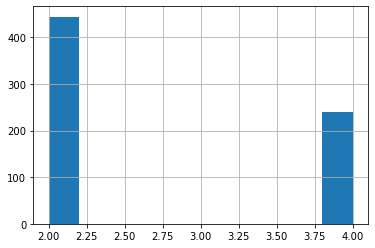

In [11]:
df['class'].hist(bins=10) 

We are going to model this problem as a binary classification problem which detects whether the tumor is malignant or not. Hence, we change the dataset so that:
* **benign(2.0) = 0**
* **malignant(4.0) = 1**

In [12]:
df['class'] = np.where(df['class'] == 2, 0, 1)

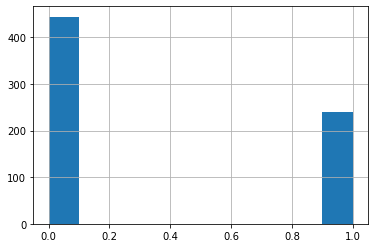

In [13]:
df['class'].hist(bins=10) 

We then split the dataset into training and testing sets. Since the number of samples is small, we will perform validation on the test set.

In [14]:
train, test = train_test_split(df, test_size = 0.2)

In [23]:
train

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
576,5,1,1,1,2,1,2,1,1
501,4,1,1,1,2,1,2,1,1
114,3,3,2,1,2,3,3,1,1
171,1,1,1,1,2,1,3,1,1
371,1,1,3,1,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...
57,8,2,4,1,5,1,5,4,4
14,8,7,5,10,7,9,5,5,4
662,1,1,3,1,2,1,2,1,1
481,5,3,2,4,2,1,1,1,1


In [24]:
test

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
299,9,1,2,6,4,10,7,7,2
450,4,1,1,3,1,1,2,1,1
223,7,5,6,3,3,8,7,4,1
676,1,1,2,1,2,1,2,1,1
644,2,1,1,1,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...
278,1,1,1,1,2,1,3,1,1
56,8,10,10,1,3,6,3,9,1
25,5,2,3,4,2,7,3,6,1
674,1,1,1,1,2,1,2,1,1


We get the statistics for training. We can look at statistics to get an idea about the distribution of plots. If you need more visualization, you can create additional data plots. We will also be using the mean and standard deviation from statistics for normalizing the data

In [15]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

In [16]:
train.describe()

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,4.529304,3.230769,3.265568,2.849817,3.305861,3.531136,3.479853,2.917582,1.642857,0.358974
std,2.806294,3.088577,2.991883,2.872101,2.277098,3.624577,2.494868,3.100545,1.793647,0.480140
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.500000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.750000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [17]:
train_stats

,count,mean,std,min,25%,50%,75%,max
clump_thickness,546.0,4.529304,2.806294,1.0,2.0,4.0,6.00,10.0
un_cell_size,546.0,3.230769,3.088577,1.0,1.0,1.0,5.00,10.0
un_cell_shape,546.0,3.265568,2.991883,1.0,1.0,1.5,5.00,10.0
marginal_adheshion,546.0,2.849817,2.872101,1.0,1.0,1.0,4.00,10.0
single_eph_cell_size,546.0,3.305861,2.277098,1.0,2.0,2.0,4.00,10.0
bare_nuclei,546.0,3.531136,3.624577,1.0,1.0,1.0,5.75,10.0
bland_chromatin,546.0,3.479853,2.494868,1.0,2.0,3.0,5.00,10.0
normal_nucleoli,546.0,2.917582,3.100545,1.0,1.0,1.0,4.00,10.0
mitoses,546.0,1.642857,1.793647,1.0,1.0,1.0,1.00,10.0


We pop the class column from the training and test sets to create train and test outputs.

In [18]:
train_Y = train.pop("class")
test_Y = test.pop("class")

In [22]:
train_Y

576    0
501    0
114    0
171    0
371    0
      ..
57     1
14     1
662    0
481    0
536    0
Name: class, Length: 546, dtype: int64

In [21]:
test_Y

299    1
450    0
223    1
676    0
644    0
      ..
278    0
56     1
25     1
674    0
304    1
Name: class, Length: 137, dtype: int64

Here we normalize the data by using the formula: **X = (X - mean(X)) / StandardDeviation(X)**

In [33]:
train.shape

(546, 9)

In [34]:
train_stats['mean'].shape

(9,)

In [35]:
train_stats['std'].shape

(9,)

In [50]:
import numpy as np
test_vec_x = np.array(range(1, 10))
test_vec_x

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [51]:
train

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
576,5,1,1,1,2,1,2,1,1
501,4,1,1,1,2,1,2,1,1
114,3,3,2,1,2,3,3,1,1
171,1,1,1,1,2,1,3,1,1
371,1,1,3,1,2,1,1,1,1
...,...,...,...,...,...,...,...,...,...
57,8,2,4,1,5,1,5,4,4
14,8,7,5,10,7,9,5,5,4
662,1,1,3,1,2,1,2,1,1
481,5,3,2,4,2,1,1,1,1


In [52]:
train.iloc[0]

clump_thickness         5
un_cell_size            1
un_cell_shape           1
marginal_adheshion      1
single_eph_cell_size    2
bare_nuclei             1
bland_chromatin         2
normal_nucleoli         1
mitoses                 1
Name: 576, dtype: int64

In [53]:
train-test_vec_x

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
576,4,-1,-2,-3,-3,-5,-5,-7,-8
501,3,-1,-2,-3,-3,-5,-5,-7,-8
114,2,1,-1,-3,-3,-3,-4,-7,-8
171,0,-1,-2,-3,-3,-5,-4,-7,-8
371,0,-1,0,-3,-3,-5,-6,-7,-8
...,...,...,...,...,...,...,...,...,...
57,7,0,1,-3,0,-5,-2,-4,-5
14,7,5,2,6,2,3,-2,-3,-5
662,0,-1,0,-3,-3,-5,-5,-7,-8
481,4,1,-1,0,-3,-5,-6,-7,-8


In [54]:
(train-test_vec_x).iloc[0]

clump_thickness         4
un_cell_size           -1
un_cell_shape          -2
marginal_adheshion     -3
single_eph_cell_size   -3
bare_nuclei            -5
bland_chromatin        -5
normal_nucleoli        -7
mitoses                -8
Name: 576, dtype: int64

In [55]:
train/test_vec_x

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
576,5.0,0.5,0.333333,0.25,0.4,0.166667,0.285714,0.125,0.111111
501,4.0,0.5,0.333333,0.25,0.4,0.166667,0.285714,0.125,0.111111
114,3.0,1.5,0.666667,0.25,0.4,0.500000,0.428571,0.125,0.111111
171,1.0,0.5,0.333333,0.25,0.4,0.166667,0.428571,0.125,0.111111
371,1.0,0.5,1.000000,0.25,0.4,0.166667,0.142857,0.125,0.111111
...,...,...,...,...,...,...,...,...,...
57,8.0,1.0,1.333333,0.25,1.0,0.166667,0.714286,0.500,0.444444
14,8.0,3.5,1.666667,2.50,1.4,1.500000,0.714286,0.625,0.444444
662,1.0,0.5,1.000000,0.25,0.4,0.166667,0.285714,0.125,0.111111
481,5.0,1.5,0.666667,1.00,0.4,0.166667,0.142857,0.125,0.111111


In [29]:
train_stats['mean']

clump_thickness         4.529304
un_cell_size            3.230769
un_cell_shape           3.265568
marginal_adheshion      2.849817
single_eph_cell_size    3.305861
bare_nuclei             3.531136
bland_chromatin         3.479853
normal_nucleoli         2.917582
mitoses                 1.642857
Name: mean, dtype: float64

In [56]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [57]:
norm_train_X = norm(train)
norm_test_X = norm(test)

In [85]:
norm_train_X.values

array([[ 0.16772867, -0.72226439, -0.75723814, ..., -0.59315914,
        -0.61846627, -0.35840787],
       [-0.18861317, -0.72226439, -0.75723814, ..., -0.59315914,
        -0.61846627, -0.35840787],
       [-0.54495501, -0.07471701, -0.42300045, ..., -0.19233626,
        -0.61846627, -0.35840787],
       ...,
       [-1.25763869, -0.72226439, -0.08876276, ..., -0.59315914,
        -0.61846627, -0.35840787],
       [ 0.16772867, -0.07471701, -0.42300045, ..., -0.99398202,
        -0.61846627, -0.35840787],
       [ 0.16772867, -0.72226439, -0.75723814, ..., -0.19233626,
        -0.61846627, -0.35840787]])

We now create Tensorflow datasets for training and test sets to easily be able to build and manage an input pipeline for our model.

In [59]:
norm_train_X.values.shape

(546, 9)

In [60]:
train_Y.values.shape

(546,)

In [62]:
len(train)

546

In [61]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

We shuffle and prepare a batched dataset to be used for training in our custom training loop.

In [63]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [71]:
for x in train_dataset.take(1):
    print(f"{x[0].shape}")
    print(f"{x[1].shape}")

(32, 9)
(32,)


In [64]:
a = enumerate(train_dataset)

print(len(list(a)))

18


In [72]:
len(train.columns)

9

## Define the Model

Now we will define the model. Here, we use the Keras Functional API to create a simple network of two `Dense` layers. We have modelled the problem as a binary classification problem and hence we add a single layer with sigmoid activation as the final layer of the model.

In [73]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

## Define Optimizer and Loss

We use RMSprop optimizer and binary crossentropy as our loss function.

In [74]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## Evaluate Untrained Model
We calculate the loss on the model before training begins.

In [131]:
norm_test_X.values.shape

(137, 9)

In [75]:
outputs = model(norm_test_X.values)
loss_value = loss_object(y_true=test_Y.values, y_pred=outputs)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.6863


We also plot the confusion matrix to visualize the true outputs against the outputs predicted by the model.

In [76]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

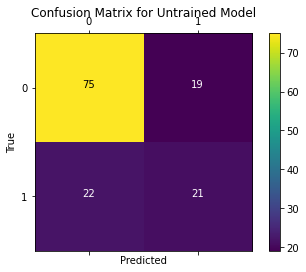

In [77]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

## Define Metrics (Please complete this section)

### Define Custom F1Score Metric
In this example, we will define a custom F1Score metric using the formula. 

**F1 Score = 2 * ((precision * recall) / (precision + recall))**

**precision = true_positives / (true_positives + false_positives)**

**recall = true_positives / (true_positives + false_negatives)**

We use `confusion_matrix` defined in `tf.math` to calculate precision and recall.

Here you can see that we have subclassed `tf.keras.Metric` and implemented the three required methods `update_state`, `result` and `reset_states`.

### Please complete the result() method:

In [78]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''
        
        # call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables
        # true positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # false positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # true negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # false negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric
        
        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''

        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)
        
        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)
      
        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Return F1 Score
        ### START CODE HERE ###
        f1_score =  2 * ((precision * recall) / (precision + recall))
        ### END CODE HERE ###
        
        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''
        
        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0) 
        self.fp.assign(0)
        self.fn.assign(0)


In [79]:
# Test Code:

test_F1Score = F1Score()

test_F1Score.tp = tf.Variable(2, dtype = 'int32')
test_F1Score.fp = tf.Variable(5, dtype = 'int32')
test_F1Score.tn = tf.Variable(7, dtype = 'int32')
test_F1Score.fn = tf.Variable(9, dtype = 'int32')
test_F1Score.result()


<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>

**Expected Output:**

```txt
<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>
```

We initialize the seprate metrics required for training and validation. In addition to our custom F1Score metric, we are also using `BinaryAccuracy` defined in `tf.keras.metrics`

In [80]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

## Apply Gradients (Please complete this section)

The core of training is using the model to calculate the logits on specific set of inputs and compute the loss(in this case **binary crossentropy**) by comparing the predicted outputs to the true outputs. We then update the trainable weights using the optimizer algorithm chosen. The optimizer algorithm requires our computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

We use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

### Please complete the following function:

In [126]:
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    applies the gradients to the trainable model weights
    
    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''
    
    with tf.GradientTape() as tape:
    ### START CODE HERE ###
        #print(f"x.shape = {x.shape}")
        #print(f"type(x) = {type(x)}")
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)
  
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    ### END CODE HERE ###
  
    return logits, loss_value

In [127]:
# Test Code:

test_model = tf.keras.models.load_model('./test_model')
test_logits, test_loss = apply_gradient(optimizer, loss_object, test_model, norm_test_X.values, test_Y.values)

print(test_logits.numpy()[:8])
print(test_loss.numpy())

del test_model
del test_logits
del test_loss

[[0.50690997]
 [0.54847735]
 [0.47968623]
 [0.54630774]
 [0.5405842 ]
 [0.4779669 ]
 [0.49051824]
 [0.548072  ]]
0.7150524


**Expected Output:**

The output will be close to these values:
```txt
[[0.5516499 ]
 [0.52124363]
 [0.5412698 ]
 [0.54203206]
 [0.50022954]
 [0.5459626 ]
 [0.47841492]
 [0.54381996]]
0.7030578
```

## Training Loop (Please complete this section)

This function performs training during one epoch. We run through all batches of training data in each epoch to make updates to trainable weights using our previous function.
You can see that we also call `update_state` on our metrics to accumulate the value of our metrics. 

We are displaying a progress bar to indicate completion of training in each epoch. Here we use `tqdm` for displaying the progress bar. 

### Please complete the following function:

In [128]:
for element in train_dataset.take(1):
    #print(f"{x.shape}")
    #print(f"{type(x)}")
    #print(f"{x.numpy().shape}")
    print(f"{element}")
    for in_ele in element:
        print(f"{tf.is_tensor(in_ele)}")
        print(f"{in_ele.shape}")
        print(f"{in_ele.numpy}")
        print(f"--------------")

(<tf.Tensor: shape=(32, 9), dtype=float64, numpy=
array([[-0.54495501, -0.72226439, -0.75723814, -0.64406403, -0.57347582,
        -0.69832571, -0.59315914, -0.61846627, -0.35840787],
       [-0.54495501, -0.72226439, -0.75723814, -0.64406403, -0.57347582,
        -0.69832571, -0.59315914, -0.61846627, -0.35840787],
       [-0.18861317, -0.72226439, -0.75723814, -0.64406403, -1.01263122,
        -0.69832571, -0.59315914, -0.61846627, -0.35840787],
       [-1.25763869, -0.72226439, -0.75723814, -0.64406403, -0.57347582,
        -0.69832571, -0.99398202, -0.61846627, -0.35840787],
       [-0.18861317, -0.3984907 , -0.75723814, -0.64406403, -0.57347582,
        -0.69832571, -0.59315914, -0.61846627, -0.35840787],
       [-0.54495501, -0.3984907 , -0.42300045, -0.64406403,  0.30483497,
        -0.14653723, -0.59315914, -0.61846627, -0.35840787],
       [-0.54495501,  0.24905668,  0.57971263,  0.05229035,  1.62230116,
        -0.14653723,  0.20848663,  0.99415352, -0.35840787],
       [ 0.1

In [129]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, 
                             train_acc_metric, train_f1score_metric, verbose=True):
    '''
    Computes the loss then updates the weights and metrics for one epoch.
    
    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    losses = []

    #Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        #Calculate loss and update trainable variables using optimizer
        ### START CODE HERE ###
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)
        ### END CODE HERE ###

        #Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')

        #Update the training metrics
        ### START CODE HERE ###
        train_acc_metric.update_state(y_true=y_batch_train, y_pred=logits)
        train_f1score_metric.update_state(y_true=y_batch_train, y_pred=logits)
        ### END CODE HERE ###

        #Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
    
    return losses

In [130]:
# TEST CODE

test_model = tf.keras.models.load_model('./test_model')

test_losses = train_data_for_one_epoch(train_dataset, optimizer, loss_object, test_model, 
                             train_acc_metric, train_f1score_metric, verbose=False)

for test_loss in test_losses:
    print(test_loss.numpy())

del test_model
del test_losses

0.75278926
0.6194535
0.5812181
0.48754328
0.4111054
0.35354084
0.406034
0.38272473
0.3757897
0.3653785
0.33351868
0.28029466
0.24957472
0.2108225
0.22411086
0.17001396
0.20693162
0.17743173


**Expected Output:**

The losses should generally be decreasing and will start from around 0.75. For example:

```
0.7600615
0.6092045
0.5525634
0.4358902
0.4765755
0.43327087
0.40585428
0.32855004
0.35755336
0.3651728
0.33971977
0.27372319
0.25026917
0.29229593
0.242178
0.20602849
0.15887335
0.090397514
```

At the end of each epoch, we have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [132]:
def perform_validation():
    losses = []

    #Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        #Calculate validation loss for current batch.
        val_logits = model(x_val) 
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        #Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        #Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)
        
    return losses

Next we define the training loop that runs through the training samples repeatedly over a fixed number of epochs. Here we combine the functions we built earlier to establish the following flow:
1. Perform training over all batches of training data.
2. Get values of metrics.
3. Perform validation to calculate loss and update validation metrics on test data.
4. Reset the metrics at the end of epoch.
5. Display statistics at the end of each epoch.

**Note** : We also calculate the training and validation losses for the whole epoch at the end of the epoch.

In [133]:
# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))
    #Perform Training over all batches of train data
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, train_acc_metric, train_f1score_metric)

    # Get results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()

    #Perform validation on all batches of test data
    losses_val = perform_validation()

    # Get results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()

    #Calculate training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

    #Reset states of all metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    val_f1score_metric.reset_states()
    train_f1score_metric.reset_states()

Start of epoch 0
Training loss for step 0: 0.6770
Training loss for step 1: 0.5259
Training loss for step 2: 0.4575
Training loss for step 3: 0.3771
Training loss for step 4: 0.3626
Training loss for step 5: 0.3180
Training loss for step 6: 0.2654
Training loss for step 7: 0.3105
Training loss for step 8: 0.2523
Training loss for step 9: 0.2293
Training loss for step 10: 0.2789
Training loss for step 11: 0.2607
Training loss for step 12: 0.2196
Training loss for step 13: 0.2481
Training loss for step 14: 0.1068
Training loss for step 15: 0.2112
Training loss for step 16: 0.1106
Training loss for step 17: 0.1414

 Epcoh 0: Train loss: 0.2974  Validation Loss: 0.1171, Train Accuracy: 0.9300, Validation Accuracy 0.9937, Train F1 Score: 0.9022, Validation F1 Score: 0.9882
Start of epoch 1
Training loss for step 0: 0.1757
Training loss for step 1: 0.1387
Training loss for step 2: 0.1071
Training loss for step 3: 0.1320
Training loss for step 4: 0.0810
Training loss for step 5: 0.1055
Traini

## Evaluate the Model

### Plots for Evaluation

We plot the progress of loss as training proceeds over number of epochs.

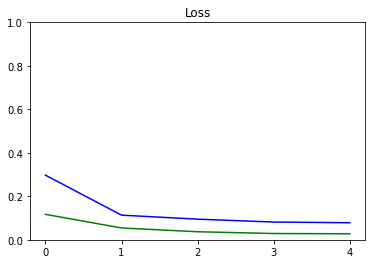

In [134]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

We plot the confusion matrix to visualize the true values against the values predicted by the model.

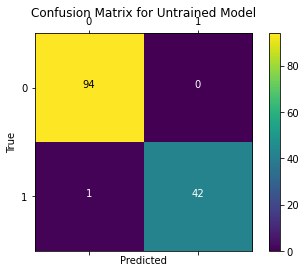

In [135]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')

In [137]:
conf_matrix = tf.math.confusion_matrix(test_Y.values, tf.round(test_outputs), num_classes=2)

In [138]:
tn = conf_matrix[0][0]
tp = conf_matrix[1][1]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
precision = tp/(tp+fp)
recall = tp/(fn+tp)
print(f"precision = {precision}")
print(f"recall = {recall}")

precision = 1.0
recall = 0.9767441860465116
